# Load data from JSON file
- Create empty dataframe
- Loop on every question/answer pair in the file
- Add a row to the dataframe for each pair

In [1]:
import json
import pandas as pd

question_df = pd.DataFrame(columns=["Question","Context","Text answer","Answer start"])

FILE_PATH = "../data/"

with open(FILE_PATH+'train.json') as json_file:
    data = json.load(json_file)
    for book in data['data']:
        for paragraph in book['paragraphs']:
            for question in paragraph['qas']:
                row = pd.Series(data={'Question' : question['question'],
                                      'Context' : paragraph['context'],
                                      'Text answer': question['answers'][0]['answer_start'],
                                      'Answer start': question['answers'][0]['text']})
                question_df = question_df.append(row,ignore_index=True)

In [2]:
display(question_df)

,Question,Context,Text answer,Answer start
0,Quel astronome a émit l'idée en premier d'une ...,L'idée selon laquelle une planète inconnue pou...,136,Johann Elert Bode
1,Quel astronome découvrit Uranus ?,L'idée selon laquelle une planète inconnue pou...,404,William Herschel
2,Quelles furent les découvertes finales des vin...,L'idée selon laquelle une planète inconnue pou...,733,plusieurs autres astéroïdes
3,Quelles furent les découvertes finales des vin...,L'idée selon laquelle une planète inconnue pou...,733,plusieurs autres astéroïdes
4,Combien de fois Piazzi est-il parvenu à observ...,"Piazzi observa Cérès 24 fois, la dernière fois...",21,24
...,...,...,...,...
20726,Qui publie un ouvrage en 1810 ?,"À partir du XVIIe siècle, les fouilles se spéc...",761,Giuseppe Micali
20727,Quel pape organise un musée grégorien ?,"Au XIXe siècle, bon nombre de sépultures sont ...",409,Grégoire XVI
20728,Où se trouve le musée grégorien ?,"Au XIXe siècle, bon nombre de sépultures sont ...",450,au Vatican
20729,Qui vole à grande échelle ?,"Au XIXe siècle, bon nombre de sépultures sont ...",959,les tombaroli


# Load the model

In [3]:
from gensim.models import KeyedVectors
import fasttext
# Load vector directly from the file
def load_model():
    try:
        # model = KeyedVectors.load_word2vec_format('../model/frWac_postag_no_phrase_1000_skip_cut100.bin', binary=True)
        model = fasttext.load_model("../model/cc.fr.300.bin")
        print("model loaded")
        return model
    except:
        print("model not found")
        
model = load_model()

model loaded


# Compute word vector

In [4]:
def get_WordVector(word,model):
    # Check if a word exists in the model
    try:
        vector = model[word]
        return vector
    except:
        print("Not found")

# Compute cosine distance between 2 words

In [5]:
from scipy import spatial

def get_cosine_distance(word_vec_1,word_vec_2):
    return (1 - spatial.distance.cosine(word_vec_1, word_vec_2))

In [6]:
print(get_cosine_distance(get_WordVector("manger",model),get_WordVector("pleurer",model)))

0.3769944906234741


# Compute sentence vector

In [7]:
from nltk.tokenize import word_tokenize

def tokenize(sentence): 
    return word_tokenize(sentence, language='french')
  
def get_SentenceVector(sentence,model):
    # splitted_sentence = tokenize(sentence)
    list_word_vectors = list()
    list_words = list()

    for word in sentence:
        word_vec = get_WordVector(word,model)
        list_word_vectors.append(word_vec)
        list_words.append(word)
    return sum(list_word_vectors)/len(sentence)

In [8]:
sentence_vec_1 = get_SentenceVector("Je mange des nougats le matin",model)
sentence_vec_2 = get_SentenceVector("Je mange des pommes",model)
print(get_cosine_distance(sentence_vec_1,sentence_vec_2))

sentence_vec_1 = get_SentenceVector("Je dors la nuit et je vole le jour",model)
sentence_vec_2 = get_SentenceVector("Je mange des pommes",model)
print(get_cosine_distance(sentence_vec_1,sentence_vec_2))

0.9729830622673035
0.9260295629501343


# Remove stop words

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
 
def rm_stop_words_nltk(sentence):
    stopWords = set(stopwords.words('french'))
    words = word_tokenize(sentence)
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [10]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
final_stopwords_list = list(fr_stop)

def rm_stop_words_spacy(sentence):
    final_stopwords_list = list(fr_stop)
    words = word_tokenize(sentence)
    wordsFiltered = []
    for w in words:
        if w not in final_stopwords_list:
            wordsFiltered.append(w)
    return wordsFiltered

In [11]:
sentence = "Je dors la nuit et je vole le jour sur un lit qui fait la taille de une mongolfiere"
print(rm_stop_words_nltk(sentence))
print(rm_stop_words_spacy(sentence))

['Je', 'dors', 'nuit', 'vole', 'jour', 'lit', 'fait', 'taille', 'mongolfiere']
['Je', 'dors', 'nuit', 'vole', 'jour', 'lit', 'taille', 'mongolfiere']


# Remove all non-alphanumeric characters

In [26]:
import re
def remove_non_alphanum_chars(sentence):
    return re.sub(r'([^\s\w]|_)+', '', sentence)

import string
def remove_non_alphanum_chars(s):
    return s.translate(str.maketrans('', '', string.punctuation))
print (remove_non_alphanum_chars("bonjour, comment allez vous?"))

bonjour comment allez vous


In [27]:
print(remove_non_alphanum_chars("Je m'appelle Basile, je suis pauvre. Je mange des gateaux."))

Je mappelle Basile je suis pauvre Je mange des gateaux


# Pre-Processing

In [14]:
def preprocess(sentence):
    # Add pre-processing steps
    sentence = remove_non_alphanum_chars(sentence)
    sentence = rm_stop_words_spacy(sentence)
    return sentence

# Get sentence answer number

In [15]:
def get_sentence_answer_num(sent_list,ans_start):
    matched_indexes = []
    #print("ans_start : ",ans_start)
    i = -1
    cpt = 0
    while cpt < ans_start:
        #print(i+1)
        cpt = cpt + len(sent_list[i+1])
        #print(cpt)
        i += 1
        
    return i

In [16]:
def get_sentence_answer_num(sent_list,ans):
    matched_indexes = []
    #print("ans_start : ",ans_start)
    ind = 0
    for index,sent in enumerate(sent_list):
        if ans in sent:
            ind = index
            break
    return ind

# Split text into sentences

In [17]:
import nltk

list_len_context = list()
feature_df = pd.DataFrame(columns=["Question","Sentences","Answer index","Answer"])
true_cpt = 0
false_cpt = 0


for index, row in question_df.iterrows():
    splitted_context = nltk.tokenize.sent_tokenize(row['Context'])   
    index_answer = get_sentence_answer_num(splitted_context,row['Answer start'])
    list_len_context.append(len(splitted_context))
    list_preprocessed_sentences = list()
    question = row['Question']
    preprocessed_question = preprocess(question)

    for sentence in splitted_context:
        preprocessed_sentence = preprocess(sentence)
        if len(sentence) != 0:
            list_preprocessed_sentences.append(preprocessed_sentence)
                 
    row = pd.Series(data={'Question' : question,
                          'Sentences': list_preprocessed_sentences,
                          'Answer index' : index_answer,
                          'Answer' : row['Answer start']})
    feature_df = feature_df.append(row,ignore_index=True)

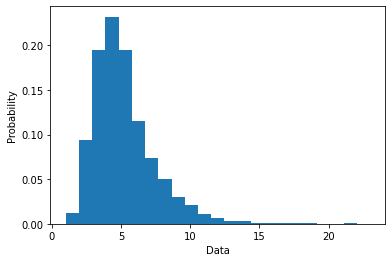

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.hist(list_len_context, density=True, bins=max(list_len_context))  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [19]:
# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 

print(Average(list_len_context))
print(max(list_len_context))
print(min(list_len_context))

4.905937967295355
23
1


In [20]:
print("false_cpt : ",false_cpt)
print("true_cpt : ",true_cpt)

false_cpt :  0
true_cpt :  0


# Save the dataframe to a csv file

In [21]:
feature_df.to_csv('../data/train.csv',index=False)